**Name:** Byaravallli Arun Suhag

**EID:** 53265857

# CS4487 - Tutorial 6
## Image Segmentation using Clustering

In this tutorial you will use clustering algorithms to generate a segmentation of an image.  An image segmentation is a separation of an image into regions belonging to distinct objects.
First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best) 
# jpg is better for images
IPython.core.display.set_matplotlib_formats("jpg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import skimage.io
import skimage.color
import skimage.util
import IPython.utils.warn as warn
random.seed(100)

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `imgdb.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the image data.

In [2]:
filelist = glob.glob('imgdb/jpg/*.jpg')
gtpath   = 'imgdb/gtruth/'
if len(filelist) == 0:
    warn.error("Could not find imgdb directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = []
    gtdata  = []
    
    # load image data
    for f in filelist:
        # load image - byte [0 to 255]
        img = skimage.io.imread(f)
        
        (fdir1, fname)  = os.path.split(f)        

        # load GT segmentation (non-consecutive integers)
        gname = gtpath + fname[:-4] + "-gt.png"
        gtimg = skimage.io.imread(gname)
        
        # convert to consecutive integers
        cl = unique(gtimg)
        gtimg0 = gtimg.copy().astype(float64)
        for i in range(len(cl)):
            gtimg0[gtimg==cl[i]] = i
        
        imgdata.append(img)
        gtdata.append(gtimg0)
print len(imgdata)

14


There are 14 images.  Each image also has a ground-truth segmentation that was created by a human annotation.  Here is an example:

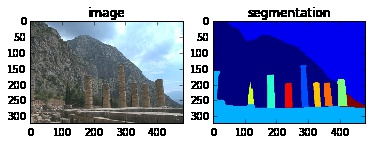

In [3]:
plt.subplot(1,2,1)
plt.imshow(imgdata[6], aspect='equal')
plt.title('image')
plt.subplot(1,2,2)
plt.imshow(gtdata[6], aspect='equal')
plt.title('segmentation');

## 2. Clustering with Color Features
To segment an image, we will extract features from each pixel location.  Then, we cluster the extracted features into groups.  Pixel location that are clustered into the same group form a segment.

For the features, we will use the "Lab" colorspace, rather than the RGB colors.  Also, we will ignore the "L" feature, which is brightness, resulting in a 2-dimensional color feature space (a, b). Here are a few helper functions: 1) extract Lab features along a regular grid on the image; 2) convert cluster labels into a segmentation image; 3) color a segmentation image using colors from the original image.

In [4]:
def getfeatures(img, stepsize=7, use_loc = False):
    """
    getfeatures - extract features from an image
     [X, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     stepsize - window stepsize
     OUTPUT
      X   - the features: each row is a feature vector  [type = np.ndarray]
      L   - dictionary containing location information of each feature
    """
    winsize = 7 # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    # convert to LAB
    yimg = skimage.color.rgb2lab(img)

    offset = floor((winsize-1)/2)
    sy,sx, sc = img.shape

    if use_loc:
        Xdim = 4
    else:
        Xdim = 2
    
    # extract window patches with stepsize
    patches = skimage.util.view_as_windows(yimg, (winsize, winsize, 3), step=stepsize)    
    psize = patches.shape
    
    # get coordinates of windows
    rangex = arange(psize[1])*stepsize + offset
    rangey = arange(psize[0])*stepsize + offset

    X = zeros((psize[0] * psize[1], Xdim));
    i = 0
    for x in range(psize[1]):
        for y in range(psize[0]):
            myu = mean(patches[y,x,0,:,:,1].flatten())
            myv = mean(patches[y,x,0,:,:,2].flatten())
            myy = rangey[y]
            myx = rangex[x]
            
            if use_loc:
                X[i,:] = [myu, myv, myx, myy]
            else:
                X[i,:] = [myu, myv]
                
            i = i + 1 
    
    L = {'rangex':rangex, 'rangey':rangey, 'offset':offset, 'sx':sx, 'sy':sy, \
         'stepsize':stepsize, 'winsize':winsize}
    return X, L

def labels2seg(Y,L):
    """
    labels2segm - form a segmentation image using cluster labels
    segm = labels2segm(Y, L)
    Y - cluster labels for each location
    L - location dictionary from getfeatures
    segm - output segmentation image
    """
    segm = zeros((L['sy'], L['sx']))
    # <= offset if floor((winsize-1)/2)>= floor(stepsize/2) 
    rstep = int(floor(L['stepsize']/2.0)) 
    stepbox = range(-rstep, L['stepsize'] - rstep)
    rx = asarray(L['rangex'], dtype=int) + int(L['offset'])
    ry = asarray(L['rangey'], dtype=int) + int(L['offset'])
    Y_reshaped = Y.reshape((ry.size, rx.size),order='F')
    for i in stepbox:
        for j in stepbox:
            segm[ix_(ry + j, rx + i)] = Y_reshaped
    ## Now fil in the borders if they are missing
    minx = min(rx) + stepbox[0] - 1
    maxx = max(rx) + stepbox[-1] + 1
    miny = min(ry) + stepbox[0] - 1
    maxy = max(ry) + stepbox[-1] + 1

    if 0 <= minx:
        ## fill in left edge
        segm[:, 0:minx+1] = segm[:,minx+1].reshape((-1,1))
    if maxx < L['sx']:
        ## fill in right edge
        segm[:,maxx:] = segm[:,maxx-1].reshape((-1,1))
    if 0 < miny:
        ## fill in top edge
        segm[0:miny+1,:] = segm[miny+1,:].reshape((1,-1))
    if maxy < L['sy']:
        ## fill in bottom edge
        segm[maxy:,:] = segm[maxy-1,:].reshape((1,-1))
    return segm    

def colorsegms(segm, img):
    """
    colorsegm - color a segmentation based on the image
    csegm = colorsegm(segm, img)
    segm = the segmentation image  [type = np.ndarray]
    img = the original image    [type = np.ndarray (or Image)]
    csegm = the colored segmentation -- each segment is colored based on the 
            average pixel color within the segment.
    """
    img = asarray(img).copy()
    if segm.shape[0:2] != img.shape[0:2]:
        raise Exception('The shape of segmentation and image are not consistent') 
    rimg, gimg, bimg = img[:,:,0], img[:,:,1], img[:,:,2]
    for i in range(0, int(max(segm.flatten())) + 1):
        # assume label starts from 1
        ind = (segm == i)
        rimg[ind] = mean(rimg[ind].flatten())
        gimg[ind] = mean(gimg[ind].flatten())
        bimg[ind] = mean(bimg[ind].flatten())
    # handle outliers from DBSCAN
    ind = (segm == -1)
    rimg[ind] = 0
    gimg[ind] = 0
    bimg[ind] = 0
    return img

Next, we use the `getfeatures` function to extract features from an image.  `X` contains the feature vectors. `L` contains information about where each features was extracted, which is used later generate the segmentation.

(3060L, 2L)


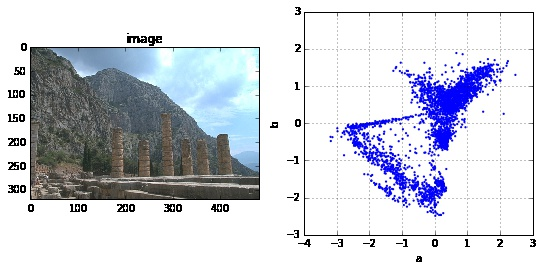

In [5]:
# image to use
img = imgdata[6]
gt  = gtdata[6]

# extract features, each row is a feature vector
Xo,L = getfeatures(img)
print Xo.shape

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# view the image
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title("image")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor='')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Now use a clustering algorithm to group the data into 5 clusters.

In [6]:
### INSERT YOUR CODE HERE

# using K-means clustering
km = cluster.KMeans(n_clusters=5, random_state=4487)
km.fit(X)
print km

axbox = [-4, 3, -3, 6]
cols = ('r', 'g', 'b', 'y', 'c')

clusterfig = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1])
plt.axis(axbox); plt.grid(True)
plt.title('data')


plt.subplot(1,2,2)
LL = []
for j in range(5):
    inds = (km.labels_ == j)
    LL.append(plt.scatter(X[inds,0], X[inds,1], c=cols[j]))
plt.axis(axbox)
plt.grid(True)
plt.title('clustered data')
leg = plt.legend(LL, ('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), fontsize=9)
leg.get_frame().set_facecolor('white')
plt.close()


Y=km.predict(X)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=4487, tol=0.0001,
    verbose=0)


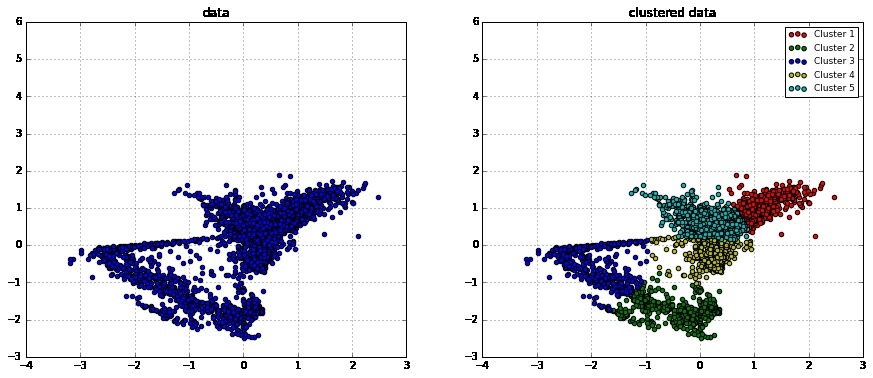

In [7]:
clusterfig

Once you have the cluster labels (Y), use the below code to generate the segmentation image and view it.  You can also view the scatter plot with `showscatter`.

In [8]:
def showsegm(segm, img):
    "show a segmentation"
    
    # fill segmentation with colors from the image
    csegm = colorsegms(segm, img)
    
    # view the images, segmentation, and ground-truth
    plt.figure(figsize=(9,6))
    plt.subplot(2,2,1)
    plt.imshow(img, interpolation='nearest')
    plt.title('image')
    plt.subplot(2,2,2)
    plt.imshow(segm, interpolation='nearest')
    plt.title('segmentation')
    plt.subplot(2,2,3)
    plt.imshow(csegm, interpolation='nearest')
    plt.title('segmentation w/ color')
    plt.subplot(2,2,4)
    plt.imshow(gt, interpolation='nearest')
    plt.title("ground truth")
    
    return segm

def showscatter(X,Y):
    "show a scatter plot of clusters"
    
    if X.shape[1] == 2:
        plt.figure()
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='')
        plt.grid(True)
        plt.xlabel('a')
        plt.ylabel('b')
    else:
        plt.figure(figsize=(9,9))

        plt.subplot(2,2,1)
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='')
        plt.xlabel('a'); plt.ylabel('b'); plt.grid(True)

        plt.subplot(2,2,2)
        plt.scatter(X[:,2], X[:,3], c=Y, s=5, edgecolor='')
        plt.xlabel('x-pos'); plt.ylabel('y-pos'); plt.grid(True)

        plt.subplot(2,2,3)
        plt.scatter(X[:,2], X[:,0], c=Y, s=5, edgecolor='')
        plt.xlabel('x-pos'); plt.ylabel('a'); plt.grid(True)

        plt.subplot(2,2,4)
        plt.scatter(X[:,3], X[:,1], c=Y, s=5, edgecolor='')
        plt.xlabel('y-pos'); plt.ylabel('b'); plt.grid(True)

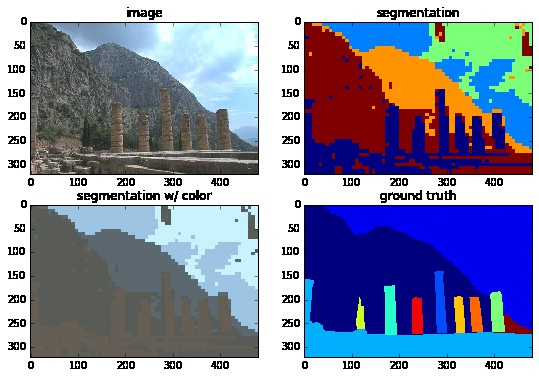

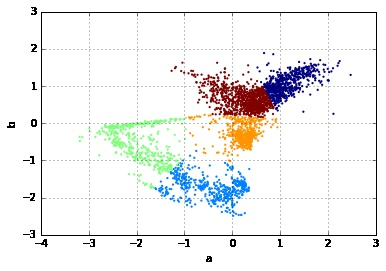

In [9]:
# convert cluster labels to a segmentation image
segm = labels2seg(Y, L)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

Next we evaluate the segmentation with the ground-truth provided by a human annotator.  We cannot just check that the cluster assignments for each pixel are the same, since the cluster indices can be permuted.  We will use the _Adjusted Rand Index_, which calculates how often a pair of pixels is assigned correctly to the same cluster or not.  Use the below code to calculate the ARI. Higher values are better, and the maximum value is 1. 

In [10]:
# calculate ARI
ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
print "ARI = " + str(ari)

ARI = 0.382439424459


Try different clustering algorithms and settings (K, bandwidth, etc) to get the best segmentation as measured by ARI. 

### MeanShift

ARI MeanShift clustering = 0.207898027838


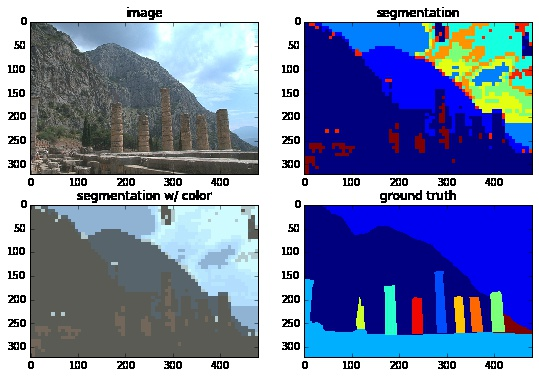

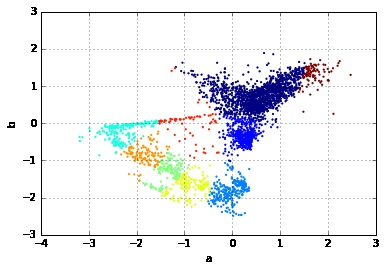

In [11]:
### INSERT YOUR CODE HERE
##MeanShift
ms = cluster.MeanShift(bandwidth=0.4, bin_seeding=True)
ms.fit(X)

cc = ms.cluster_centers_  # cluster centers
cl = ms.labels_           # labels

Y  = ms.predict(X)  # predict cluster index for training set
segm = labels2seg(Y, L)

# fill segmentation with colors from the image
csegm = colorsegms(segm, img)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
print "ARI MeanShift clustering = " + str(ari)

### SpectralClustering

ARI SpectralClustering = 0.447874886554


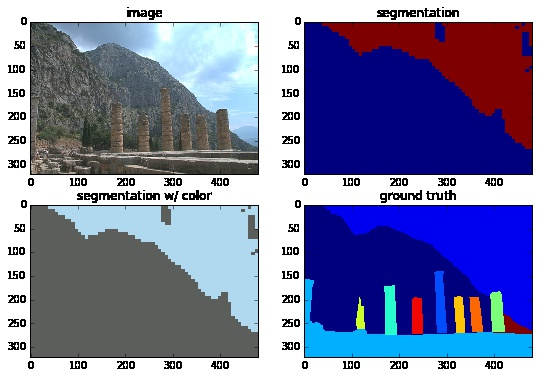

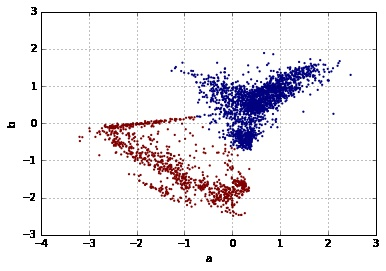

In [12]:
sc = cluster.SpectralClustering(n_clusters=2, affinity='rbf', gamma=1.0, assign_labels='discretize')
Y = sc.fit_predict(X)  # cluster and also return the labels Y
segm = labels2seg(Y, L)
csegm = colorsegms(segm, img)
# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
print "ARI SpectralClustering = " + str(ari)

### GMM

ARI GMM Clustering = 0.359329507263


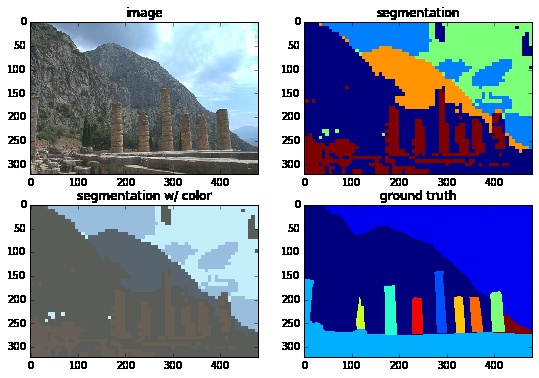

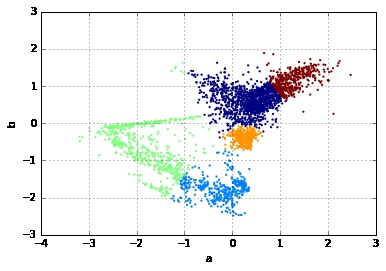

In [13]:
gmm = mixture.GMM(n_components=5, covariance_type='spherical', random_state=11, n_init=1, init_params='wc')

# initialize means with a random data point
gmm.fit(X)
Y  = gmm.predict(X)  # predict cluster index for training set
segm = labels2seg(Y, L)
# convert cluster labels to a segmentation image
segm = labels2seg(Y, L)
# fill segmentation with colors from the image
csegm = colorsegms(segm, img)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
print "ARI GMM Clustering = " + str(ari)

### Trying different  settings for each culster to find the best results

In [14]:
max_ari_kmeans = [0,0]
max_ari_gmm = [0,0,'']
max_ari_dirc = [0,0,'']
max_ari_ms = [0,0]
max_ari_spectral = [0,0]


### K-Means 
for i in range(2,20,1):
    km = cluster.KMeans(n_clusters=i, random_state=4487)
    km.fit(X)
    Y = km.predict(X)
    segm = labels2seg(Y, L)
    ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
    if ari > max_ari_kmeans[0]:
        max_ari_kmeans[0] = ari
        max_ari_kmeans[1] = i

print "For K-Means, the best ari value is achieved at (ari value, k value) = " + str(max_ari_kmeans)

#Mean Shift
for i in arange(0.1,4,0.1):
    ms = cluster.MeanShift(bandwidth=i, bin_seeding=True)
    ms.fit(X)

    cc = ms.cluster_centers_  # cluster centers
    cl = ms.labels_           # labels

    Y  = ms.predict(X)  # predict cluster index for training set
    segm = labels2seg(Y, L)
    # convert cluster labels to a segmentation image
    segm = labels2seg(Y, L)
    ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
    if ari > max_ari_ms[0]:
        max_ari_ms[0] = ari
        max_ari_ms[1] = i
print "For mean shift, the best ari value is achieved at (ari value, k value) = " + str(max_ari_ms)

# Spectral Clustering
for i in arange(2,20,1):
    sc = cluster.SpectralClustering(n_clusters=i, affinity='rbf', gamma=1.0, assign_labels='discretize')
    Y = sc.fit_predict(X)  # cluster and also return the labels Y
    segm = labels2seg(Y, L)
    ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
    if ari > max_ari_spectral[0]:
        max_ari_spectral[0] = ari
        max_ari_spectral[1] = i
print "For spectral clustering, the best ari value is achieved at (ari value, k value) = " + str(max_ari_spectral)

### GMM
type_ = ['diag', 'spherical', 'full']
for i in range(2,20,1):
    for st in type_:
        gmm = mixture.GMM(n_components=i, covariance_type=str(st), random_state=4311, n_init=1, init_params='wc')

        # initialize means with a random data point
        gmm.fit(X)
        Y  = gmm.predict(X)  # predict cluster index for training set
        segm = labels2seg(Y, L)
        ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
        if ari > max_ari_gmm[0]:
            max_ari_gmm[0] = ari
            max_ari_gmm[1] = i
            max_ari_gmm[2] = st

print "For GMM, the best ari value is achieved at (ari value, k value) = " + str(max_ari_gmm)

For K-Means, the best ari value is achieved at (ari value, k value) = [0.5357692889856138, 4]
For mean shift, the best ari value is achieved at (ari value, k value) = [0.44963660739847006, 1.4000000000000001]
For spectral clustering, the best ari value is achieved at (ari value, k value) = [0.5369208180106291, 4]
For GMM, the best ari value is achieved at (ari value, k value) = [0.5018605952828378, 4, 'spherical']


_Which algorithm performs the best?  Why?_
- **Spectral Clustering gives the best ARI (0.5369).**
- **For the give test image, it contains polygonal rectangles which can be seen as a graph of connected voxels.Spectral algorithm chooses graph cuts while minimizing the ratio of the gradient along the cut and volume of the region. It balances the volume( region sizes)**
- **The structure of individual clusters is a bit non-convex and spectral clustering works well in these cases**
- **Spectral clustering algorithm can handle clusters of any shape as long as they are connected.**

## 3. Color and Position Features
You may notice that the segmentation is not spatially smooth -- that is, there are some "loner" pixels that are not the same cluster as the surrounding pixels.  This is because we are only clustering color.  One way to fix this is to include the (x,y) coordinate of the pixel as part of the feature vector.  This way, clusters will have pixels that are spatially close together.

The below code extracts a 4-dimensional feature vector, where the first 2 features are the color channels and the last 2 features are the position.

In [15]:
# extract features with location
Xo,L = getfeatures(img, use_loc=True)
print Xo.shape

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# rescale position features
# larger values emphasize clustering by position more
X[:,2:4] *= 0.5

(3060L, 4L)


Here are plots of the 4 features.

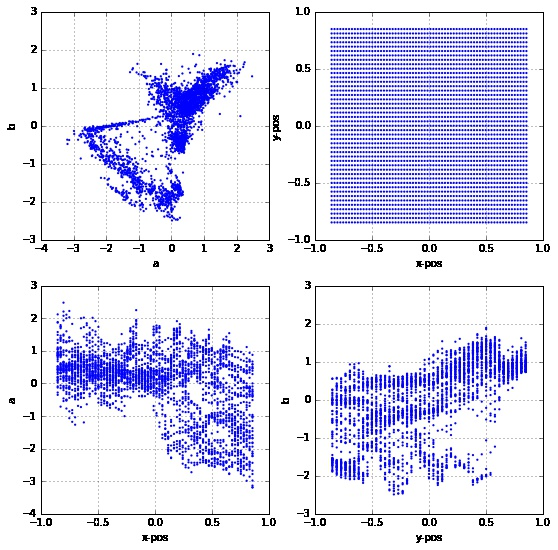

In [16]:
# view features
plt.figure(figsize=(9,9))

plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor='')
plt.xlabel('a'); plt.ylabel('b'); plt.grid(True)

plt.subplot(2,2,2)
plt.scatter(X[:,2], X[:,3], c='b', s=5, edgecolor='')
plt.xlabel('x-pos'); plt.ylabel('y-pos'); plt.grid(True)

plt.subplot(2,2,3)
plt.scatter(X[:,2], X[:,0], c='b', s=5, edgecolor='')
plt.xlabel('x-pos'); plt.ylabel('a'); plt.grid(True)

plt.subplot(2,2,4)
plt.scatter(X[:,3], X[:,1], c='b', s=5, edgecolor='')
plt.xlabel('y-pos'); plt.ylabel('b'); plt.grid(True)

Run clustering algorithms on the 4-dimensional data.  Try different algorithms and parameters to get the best ARI.

For mean shift, the best ari value is achieved at (ari value, k value) = [0.2736609057104809, 1]


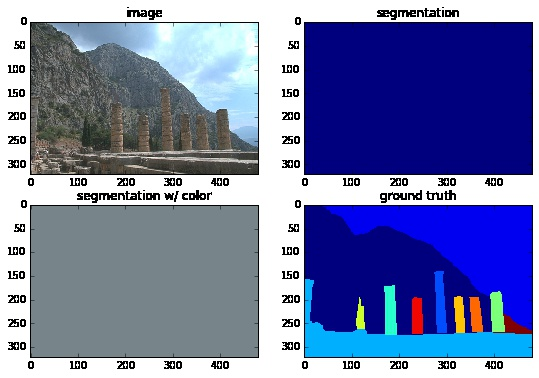

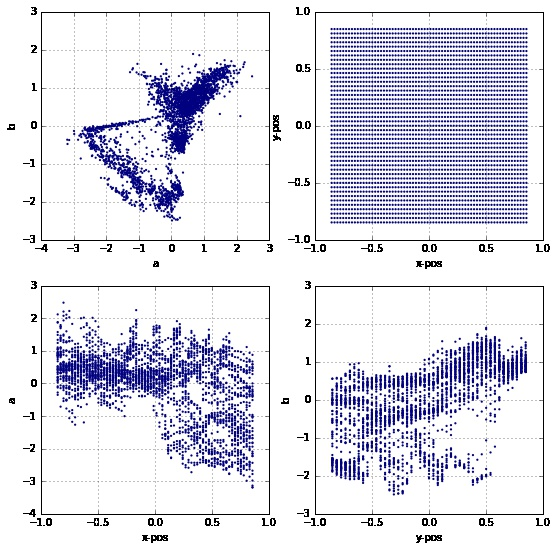

In [17]:
### INSERT YOUR CODE HERE
#Mean Shift
max_ari_ms = [0,0] # [max ari, bandwidth that yields max ari]
for i in range(1,10,1):
    ms = cluster.MeanShift(bandwidth=i, bin_seeding=True)
    ms.fit(X)

    Y  = ms.predict(X)  # predict cluster index for training set
    # convert cluster labels to a segmentation image
    segm = labels2seg(Y, L)
    ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
    if ari > max_ari_ms[0]:
        max_ari_ms[0] = ari
        max_ari_ms[1] = i
print "For mean shift, the best ari value is achieved at (ari value, k value) = " + str(max_ari_ms)

ms = cluster.MeanShift(bandwidth=max_ari_ms[1], bin_seeding=True)
ms.fit(X)
segm = labels2seg(Y, L)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

For K-Means, the best ari value is achieved at (ari value, k value) = [0.6037546695140711, 4]


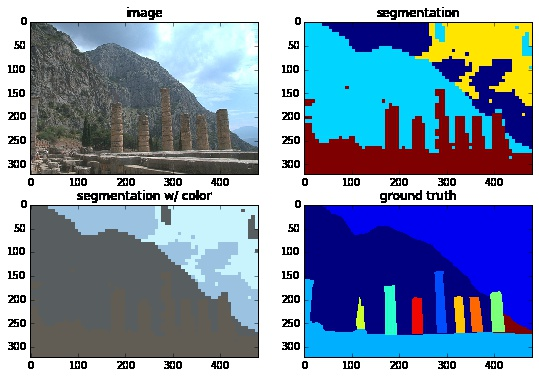

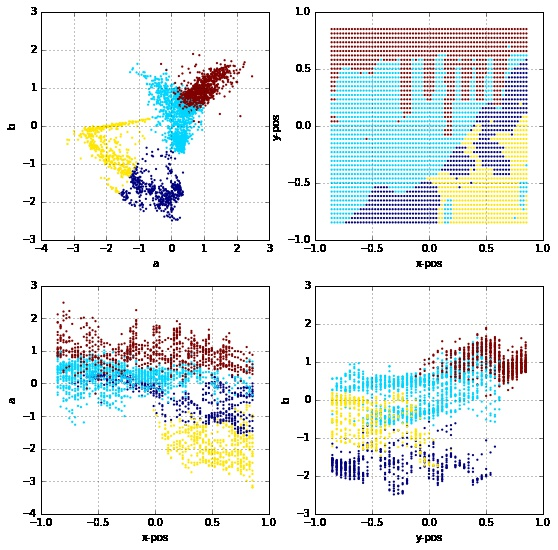

In [18]:
# using K-means clustering
max_ari_kmeans = [0,0] # [max ari, number of clusters that yields max ari]

### K-Means 
for i in range(2,20,1):
    km = cluster.KMeans(n_clusters=i, random_state=4487)
    km.fit(X)
    Y = km.predict(X)
    segm = labels2seg(Y, L)
    ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
    if ari > max_ari_kmeans[0]:
        max_ari_kmeans[0] = ari
        max_ari_kmeans[1] = i

print "For K-Means, the best ari value is achieved at (ari value, k value) = " + str(max_ari_kmeans)

km = cluster.KMeans(n_clusters=max_ari_kmeans[1], random_state=4487)
km.fit(X)
Y = km.predict(X)
segm = labels2seg(Y, L)
# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

For GMM, the best ari value is achieved at (ari value, k value) = [0.6905650795721863, 4, 'full']


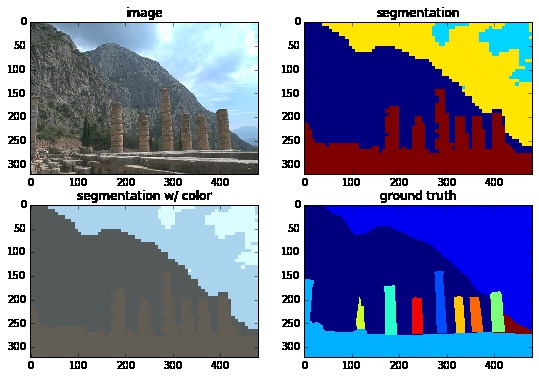

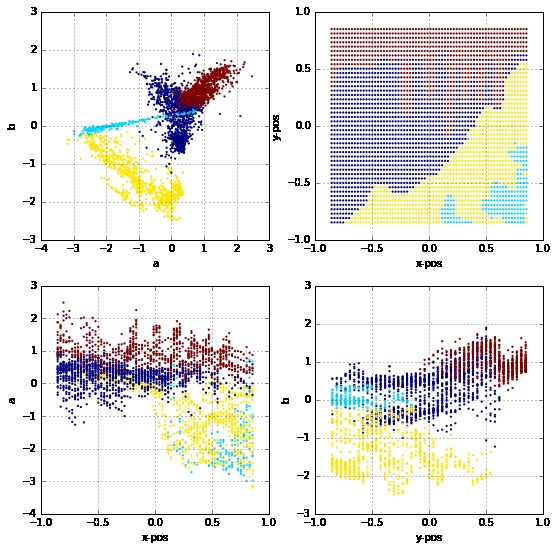

In [19]:
### GMM
max_ari_gmm = [0,0,''] # [max ari, number of clusters that yields max ari, covariance type that yields max ari]

type_ = ['diag', 'spherical', 'full']
for i in range(2,20,1):
    for st in type_:
        gmm = mixture.GMM(n_components=i, covariance_type=str(st), random_state=4311, n_init=1, init_params='wc')

        # initialize means with a random data point
        gmm.fit(X)
        Y  = gmm.predict(X)  # predict cluster index for training set
        segm = labels2seg(Y, L)
        ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
        if ari > max_ari_gmm[0]:
            max_ari_gmm[0] = ari
            max_ari_gmm[1] = i
            max_ari_gmm[2] = st

print "For GMM, the best ari value is achieved at (ari value, k value) = " + str(max_ari_gmm)
gmm = mixture.GMM(n_components=max_ari_gmm[1], covariance_type=max_ari_gmm[2], random_state=4311, n_init=1, init_params='wc')
gmm.fit(X)
Y  = gmm.predict(X)  # predict cluster index for training set
segm = labels2seg(Y, L)
# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)



For spectral clustering, the best ari value is achieved at (ari value, k value) = [0.59031372200844, 4]


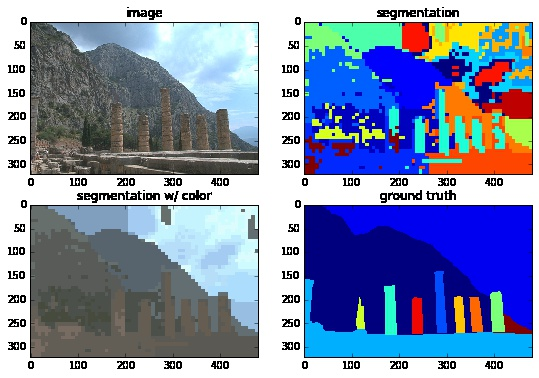

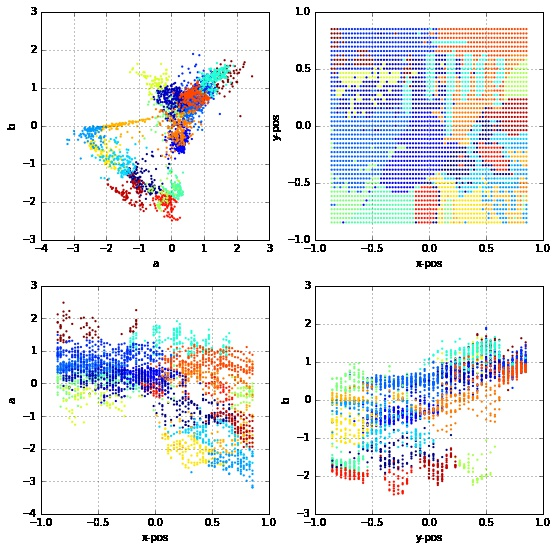

In [20]:
# Spectral Clustering
max_ari_spectral = [0,0] #[max ari, number of clusters that yields max ari]
for i in arange(2,20,1):
    sc = cluster.SpectralClustering(n_clusters=i, affinity='rbf', gamma=1.0, assign_labels='discretize')
    Y = sc.fit_predict(X)  # cluster and also return the labels Y
    segm = labels2seg(Y, L)
    ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
    if ari > max_ari_spectral[0]:
        max_ari_spectral[0] = ari
        max_ari_spectral[1] = i
print "For spectral clustering, the best ari value is achieved at (ari value, k value) = " + str(max_ari_spectral)


sc = cluster.MeanShift(bandwidth=max_ari_spectral[1], bin_seeding=True)
ms.fit(X)
segm = labels2seg(Y, L)
# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

2.0%
9.0%
16.0%
23.0%
30.0%
37.0%
44.0%
51.0%
58.0%
65.0%
72.0%
79.0%
86.0%
93.0%
100.0%
For dpgmm clustering, the best ari value is achieved at (ari value, k value) = [0.6771290380355941, 2.9000000000000004, 13, 'diag']


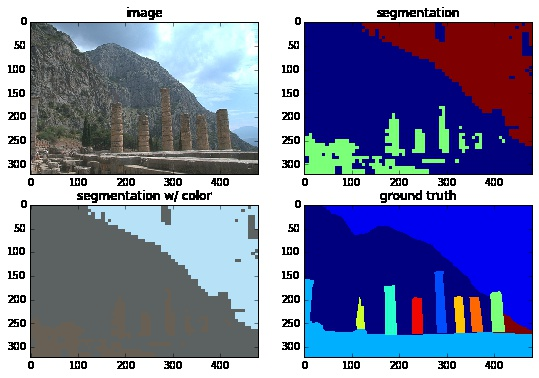

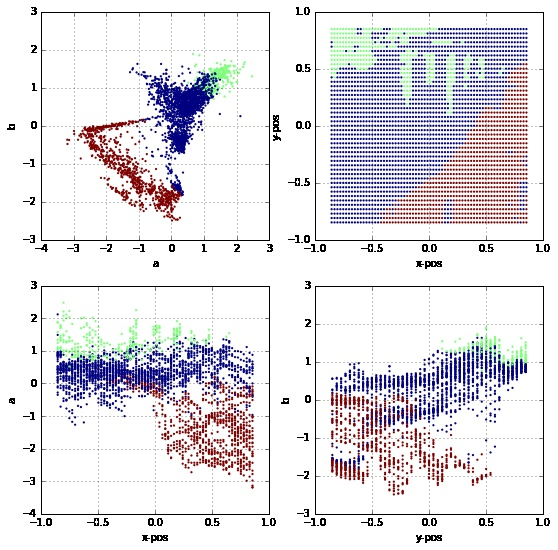

In [21]:
#DPGMM
max_ari_dpgmm = [0,0.0,0,''] #[max ari, max alpha, number of clusters that yields max ari, covariance type that yields max ari]
random.seed(123)

for i in linspace(0.1,5,15):
    print str(i/5*100) + "%" 
    for j in range (1,15,1):
        for st in type_:
            # alpha = concentration parameter
            # n_components = the max number of components to consider
            dpgmm = mixture.DPGMM(covariance_type=st, alpha=i, n_components=j, n_iter=100)
            dpgmm.fit(X)
            Y  = dpgmm.predict(X)  # predict cluster assignments
            segm = labels2seg(Y, L)
            ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
            if ari > max_ari_dpgmm[0]:
                    max_ari_dpgmm[0] = ari
                    max_ari_dpgmm[1] = i
                    max_ari_dpgmm[2] = j
                    max_ari_dpgmm[3] = st
    
dpgmm = mixture.DPGMM(covariance_type=str(max_ari_dpgmm[3]), alpha=max_ari_dpgmm[1], n_components=max_ari_dpgmm[2], n_iter=100)
dpgmm.fit(X)
Y  = dpgmm.predict(X)  # predict cluster assignments
segm = labels2seg(Y, L)
# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

print "For dpgmm clustering, the best ari value is achieved at (ari value, k value) = " + str(max_ari_dpgmm)

_ Which method performs the best?  Why?_
- **GMM ('full' covariance, and n=4)  performs the best, and yields a very high ARI of 0.697. This is evident from the visualisation.**
- **This is because the ellipical shape of the clusters trace the trend more accurately compared to other methods. **

_Does including the position features improve the segmentation results?_
- **Yes it helps in achieving a higher ARI**
- **when clustering a color pixel for obtaining segmentation, there are some "loner" pixels that are not the same cluster as the surrounding pixels. Thus to smoothen the clustering we include position as part of the fearture vector and this helps clusters to have pixels that are spatially close together.**
- **Position vectors help in dilineating clusters corresponding to compact regions of the image**
- **If position features are not used , compact regions cannot be identified ( They are scattered around the image**